#  <center>**Maestría en Ciencia de Datos y Analítica**</center>
## <center>**Estadística en Análitica: Taller 2**</center>
### <center>**Autores**:</center>
#### <center>**Sebastian Carvalho Salazar**</center>
#### <center>**Johan Stiven Paez Bermudez**</center>
#### <center>**Sebastian Ramirez Escobar**</center>

# Importar Librerias
---

In [641]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from itertools import combinations
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import time
import pickle

## Clase para Detección de Fraudes en Tarjetas de Crédito

La clase `CreditCardFraudDetection` se ha creado con el propósito de simplificar y automatizar el proceso de detección de fraudes en transacciones de tarjetas de crédito mediante el uso de técnicas de aprendizaje automático y análisis de datos. Algunos de los objetivos clave de esta clase incluyen:

- **Preprocesamiento de datos**, que abarca la división de datos, imputación de valores faltantes, pruebas de t-student, y eliminación de valores atípicos.
- **Entrenamiento de modelos de detección de fraudes**, permitiendo la búsqueda de hiperparámetros y el uso de modelos predeterminados.
- **Evaluación del rendimiento del modelo** con métricas como precisión, F1-score, precisión y recuperación, así como una matriz de confusión.
- **Análisis de correlación** entre variables del conjunto de datos.
- **Visualización de la importancia de las características** en el modelo.
- **Análisis de cajas (box plots)** para investigar características específicas en función del fraude.

In [642]:
class CreditCardFraudDetection:
    def __init__(self, data):
        self.data = data
        self.preprocess_data()

    def preprocess_data(self):
        self.X = self.data.drop('fraud', axis=1)
        self.y = self.data['fraud']

    def split_data(self, test_size=0.2, random_state=None):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state)

    def train_model(self, model, params=None, cv=5, metric=None, save_model_path=None):
        if params:
            grid_search = GridSearchCV(model, params, cv=cv, scoring=metric)
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            print(self.model)
            print(grid_search.best_estimator_)
        else:
            self.model = model
            self.model.fit(self.X_train, self.y_train)

        columns = self.X.columns
        importances = self.model.feature_importances_
        sns.barplot(y = columns, x = importances, linewidth = 1)
        plt.title("Importancia de las características", fontweight='bold')
        plt.xlabel("Importancia")
        plt.ylabel("Características")
        plt.grid(True)
        plt.show()

        if save_model_path:
            with open(save_model_path, 'wb') as model_file:
                pickle.dump(self.model, model_file)

    def evaluate_model(self):
        predictions = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, predictions)
        f1 = f1_score(self.y_test, predictions)
        precision = precision_score(self.y_test, predictions)
        recall = recall_score(self.y_test, predictions)
        conf_matrix = confusion_matrix(self.y_test, predictions)
        sns.heatmap(conf_matrix, annot=True)
        print("="*100)
        results_df = pd.DataFrame({
            "accuracy": [accuracy],
            "f1_score": [f1],
            "precision": [precision],
            "recall": [recall],
        })
        return results_df

    def correlation_analysis(self):
        corr = self.data.corr()
        plt.figure(figsize=(8,5))
        sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='jet')
        plt.show()

    def report_missing_data(self):
        return self.X.isnull().sum()

    def impute_missing_data(self):
        imputer = SimpleImputer(strategy='median')
        self.X = pd.DataFrame(imputer.fit_transform(self.X), columns=self.X.columns)

    def perform_t_tests(self):
        continue_vars = self.X.select_dtypes(include=[np.number]).columns[self.X.nunique() != 2]
        results = []

        for var in continue_vars:
            group1 = self.data[self.data['fraud'] == 0][var]
            group2 = self.data[self.data['fraud'] == 1][var]

            t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
            results.append({
                'Variable': var,
                'P-Value': p_value
            })

        return pd.DataFrame(results)

    def remove_outliers(self, iqr_factor=1.5):
        def calculate_and_remove_outliers(df):
            Q1 = df.quantile(0.25)
            Q3 = df.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_factor * IQR
            upper_bound = Q3 + iqr_factor * IQR
            return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

        fraud_data = self.data[self.data['fraud'] == 1]
        non_fraud_data = self.data[self.data['fraud'] == 0]

        filtered_fraud_data = calculate_and_remove_outliers(fraud_data.drop('fraud', axis=1))
        filtered_non_fraud_data = calculate_and_remove_outliers(non_fraud_data.drop('fraud', axis=1))

        filtered_fraud_data['fraud'] = 1
        filtered_non_fraud_data['fraud'] = 0

        self.data = pd.concat([filtered_fraud_data, filtered_non_fraud_data])
        self.preprocess_data()

    def boxplot_analysis(self):
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

        variables = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']

        for i, var in enumerate(variables):
            self.data.boxplot(column=var, by='fraud', ax=axes[i])
            axes[i].set_title(var)
            axes[i].set_xlabel('Fraud')
            axes[i].set_ylabel(var)

        plt.tight_layout()
        plt.show()

# Importar datos
---

In [643]:
# Aplicación de la clase al conjunto de datos
data = pd.read_csv('/content/card_transdata.csv', sep=',')
data.head(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


La imagen muestra un gráfico de barras que representa la distribución de clases de fraude en transacciones con tarjetas de crédito, donde la clase 0 (no fraude) tiene una frecuencia mucho mayor que la clase 1 (fraude). Esto indica un desbalanceo significativo, donde las transacciones legítimas (no fraude) ocurren con mucha más frecuencia que las transacciones fraudulentas. Este desbalanceo es común en datos de fraude de tarjetas de crédito, ya que la gran mayoría de las transacciones son legítimas y solo un pequeño porcentaje es fraudulento.

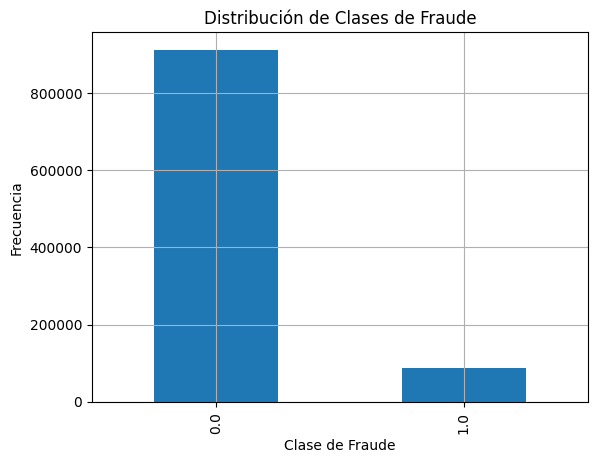

In [644]:
data["fraud"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("Clase de Fraude")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases de Fraude")
plt.show()

# Análisis de datos (Análisis inicial)
---

## Instanciar clase

In [645]:
fraud_detection = CreditCardFraudDetection(data)

## Datos nulos:
- No se observan datos nulos.

In [646]:
fraud_detection.report_missing_data()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
dtype: int64

Los **boxplots** presentan la distribución de tres variables continuas relacionadas con transacciones de tarjetas de crédito, comparando entre transacciones legítimas \(0\) y fraudulentas \(1\). En las tres variables —*distancia desde el hogar*, *distancia desde la última transacción* y la *relación con el precio de compra mediano*— hay una presencia notable de valores atípicos (outliers).

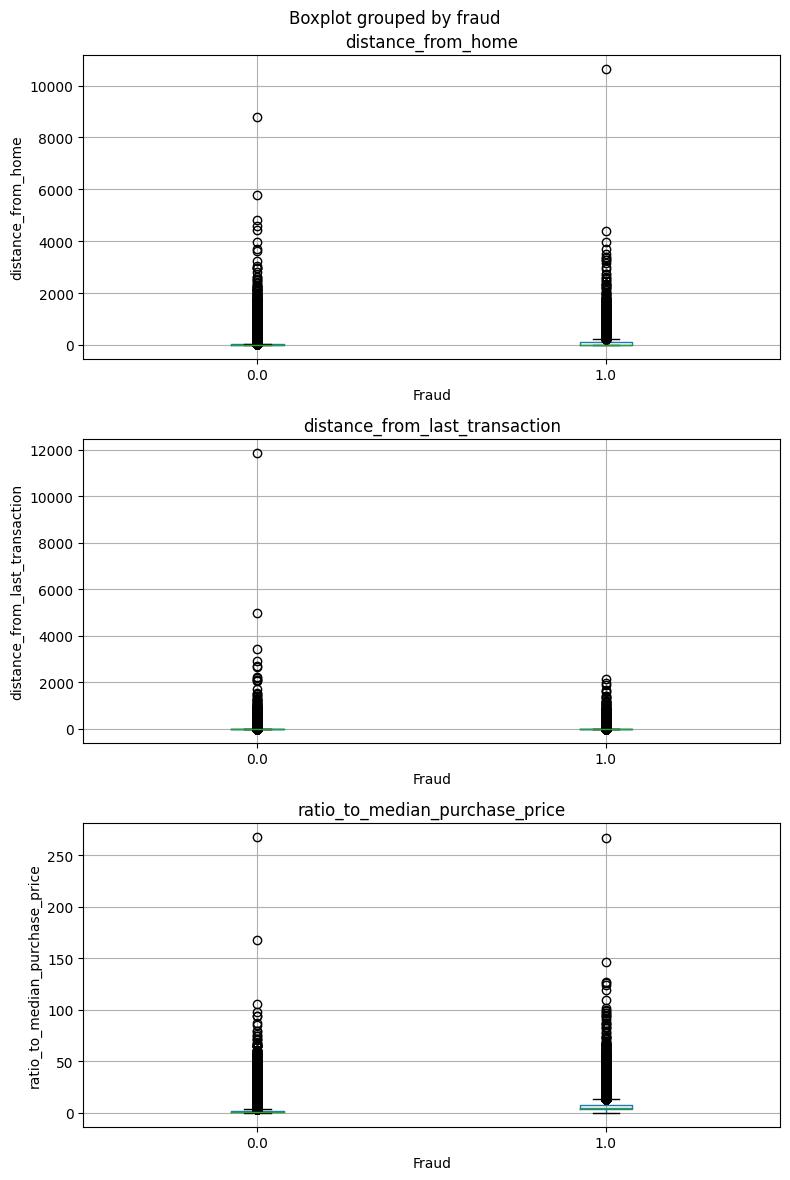

In [647]:
fraud_detection.boxplot_analysis()

La **matriz de correlación** muestra las relaciones entre diferentes variables asociadas con transacciones de tarjetas de crédito. Los valores de correlación cercanos a 1 o -1 indican una fuerte relación lineal positiva o negativa, respectivamente. Aquí, la variable 'fraud' muestra una correlación moderadamente positiva con 'ratio_to_median_purchase_price' (0.46), lo que sugiere que cuanto mayor es la desviación del precio de compra respecto a la mediana, más probable es que la transacción sea fraudulenta. Además, hay una correlación positiva más débil con 'distance_from_home' (0.19) y 'online_order' (0.19), indicando que las transacciones realizadas lejos de casa o en línea podrían tener un mayor riesgo de ser fraudulentas. Las demás variables muestran correlaciones muy bajas con 'fraud', lo que implica una relación lineal débil o inexistente con respecto a la ocurrencia de fraude en este conjunto de datos.

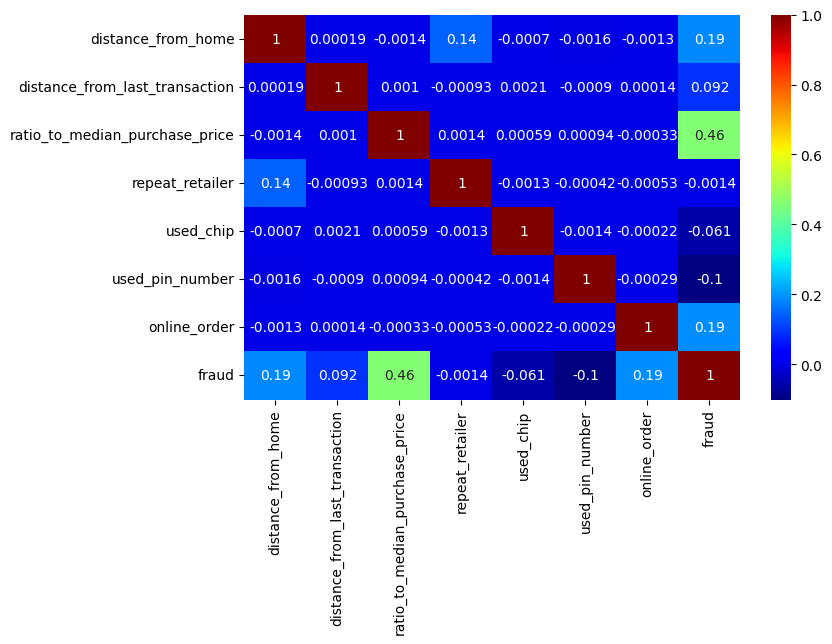

In [648]:
fraud_detection.correlation_analysis()

# Análisis de datos (Análisis Posterior)
---

## Outliers

Se han removido los valores atípicos del conjunto de datos usando el rango intercuartílico (IQR).para esto se separan los datos en transacciones fraudulentas y no fraudulentas, se eliminan los valores atípicos de cada grupo y luego se combinan los datos limpios.

In [649]:
fraud_detection.remove_outliers(iqr_factor=1.5)
print(data.shape)
data_without_outliers = fraud_detection.data
print(data_without_outliers.shape)

(1000000, 8)
(591095, 8)


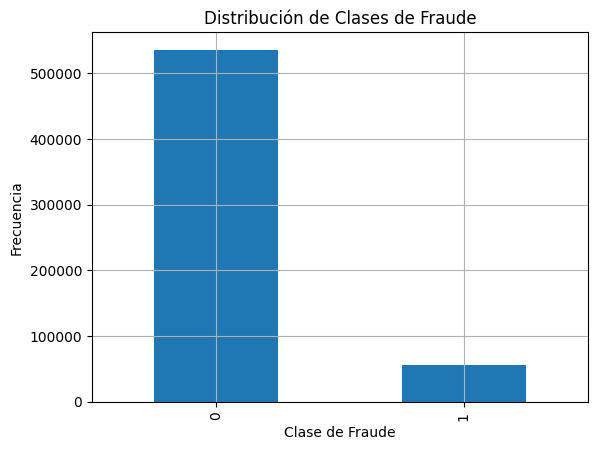

In [650]:
data_without_outliers["fraud"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("Clase de Fraude")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases de Fraude")
plt.show()

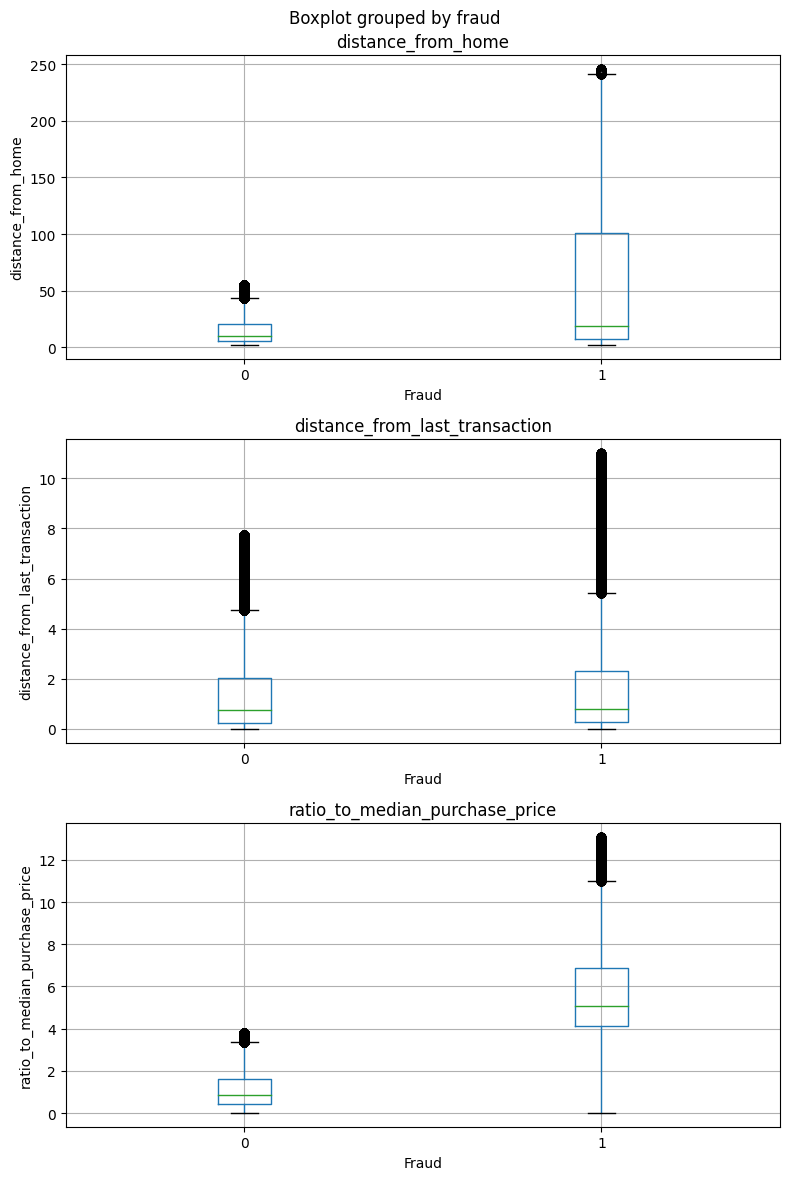

In [651]:
fraud_detection.boxplot_analysis()

## Imputación

- No fue necesario.

In [652]:
# fraud_detection.impute_missing_data()

## Correlación

La matriz de correlación modificada muestra que, después de eliminar outliers, algunas variables solo tienen una categoría predominante, indicado por la ausencia de valores en ciertas celdas. Esto sugiere que la eliminación de valores atípicos ha resultado en una uniformidad donde ciertas características solo presentan un tipo de comportamiento o valor. Por ejemplo, las variables 'used_chip' y 'used_pin_number' no muestran ninguna correlación con otras, lo que puede significar que, después de la limpieza, todos los registros en el conjunto de datos resultante tienen el mismo valor para estas variables, perdiendo su variabilidad. En cuanto a las variables restantes, 'distance_from_home' y 'ratio_to_median_purchase_price' muestran una fuerte correlación con 'fraud' (0.43 y 0.7, respectivamente), lo que resalta su importancia potencial en la identificación de transacciones fraudulentas.

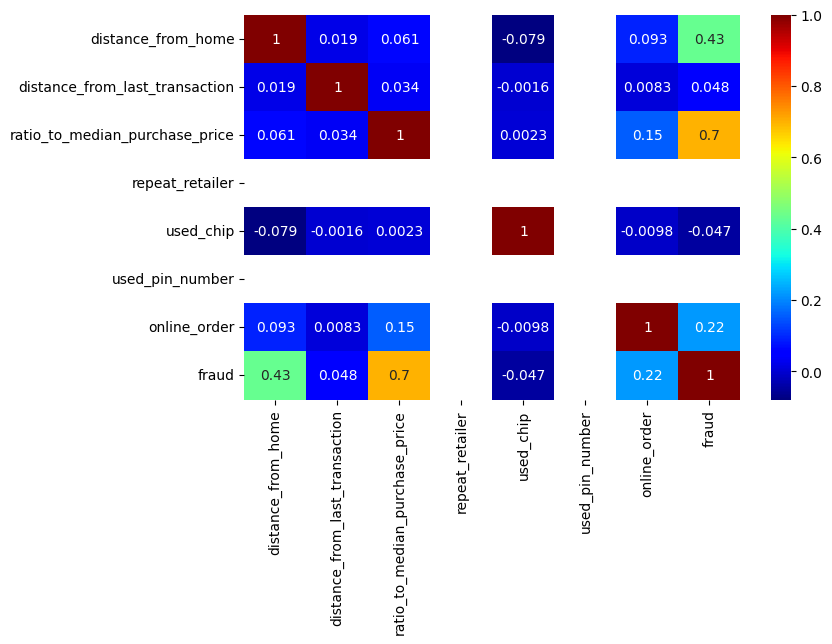

In [653]:
fraud_detection.correlation_analysis()

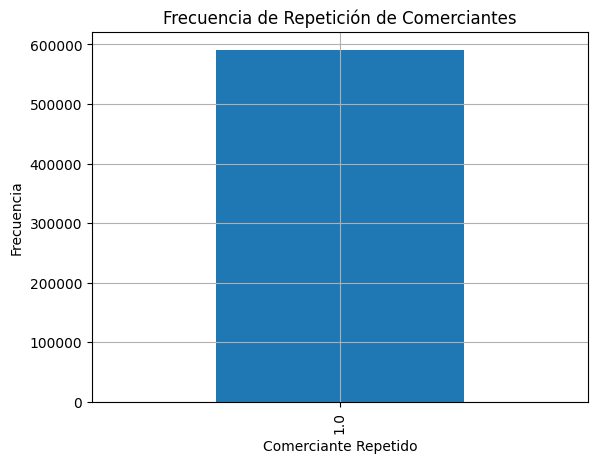

In [654]:
data_without_outliers['repeat_retailer'].value_counts().plot(kind='bar', grid=True)
plt.title("Frecuencia de Repetición de Comerciantes")
plt.xlabel("Comerciante Repetido")
plt.ylabel("Frecuencia")
plt.show()

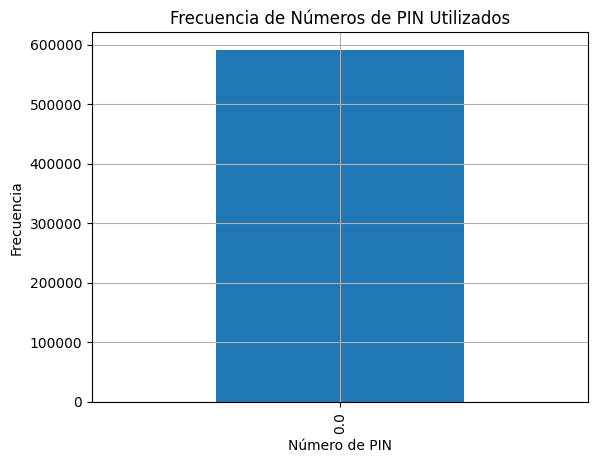

In [655]:
data_without_outliers['used_pin_number'].value_counts().plot(kind='bar', grid=True)
plt.title("Frecuencia de Números de PIN Utilizados")
plt.xlabel("Número de PIN")
plt.ylabel("Frecuencia")
plt.show()

In [656]:
data_without_outliers = data_without_outliers.drop(['repeat_retailer','used_pin_number'], axis = 1)

## Undersampling

Este paso se a implementado en el conjunto de datos con el objetivo de acelerar los procesos de análisis y modelado debido a la gran cantidad de datos y la lentitud resultante en la ejecución del script. Se ha recurrido al undersampling de la clase mayoritaria (clase 0, no fraude) tomando una fracción aleatoria de estos datos (en este caso, el 10%) para equilibrar las clases y reducir el tiempo de procesamiento. Este enfoque es un compromiso que permite obtener resultados más rápidos a costa de utilizar menos datos.

Mas adelante se a obtado por usar un RandomForestClassifier ya que se alinea con las características del problema: los métodos basados en árboles de decisión como los Random Forests son robustos frente a clases desbalanceadas y tienen la ventaja de que, generalmente, no requieren normalización o estandarización de los datos.

Se ha decidido utilizar el DataFrame data_without_outliers_no_undersampling, que contiene los datos de la clase mayoritaria que no fueron incluidos en el muestreo aleatorio (undersampling), para realizar una prueba final del modelo.

In [657]:
# Separar las clases en dos DataFrames
cero_label = data_without_outliers[data_without_outliers['fraud'] == 0]
one_label = data_without_outliers[data_without_outliers['fraud'] == 1]

# Seleccionar una muestra aleatoria de la clase mayoritaria (clase 0) con una proporción deseada
proporcion_deseada = 0.1
cero_label_undersampled = cero_label.sample(frac=proporcion_deseada, random_state=42)

# Crear otro DataFrame con los datos que no se utilizaron para el undersampling
cero_label_no_undersampled = cero_label.drop(cero_label_undersampled.index)

# Combinar las muestras de ambas clases en el DataFrame de undersampling
data_without_outliers_undersampling = pd.concat([cero_label_undersampled, one_label])

# Crear otro DataFrame con los datos que no se utilizaron para el undersampling
data_without_outliers_no_undersampling = cero_label_no_undersampled

# Actualizar los datos de la instancia de 'fraud_detection'
fraud_detection.X = data_without_outliers_undersampling.drop(['fraud'], axis=1)
fraud_detection.y = data_without_outliers_undersampling['fraud']

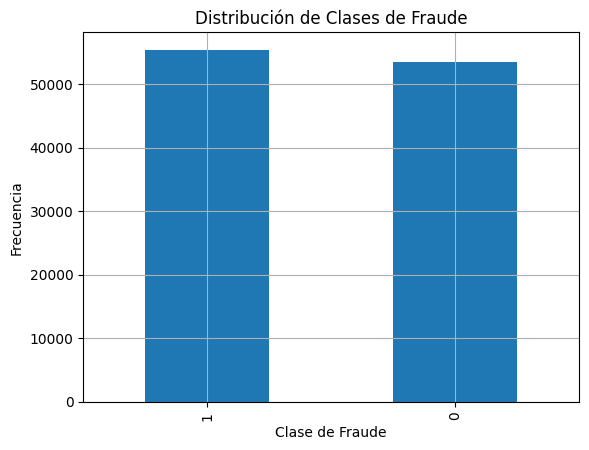

In [658]:
data_without_outliers_undersampling["fraud"].value_counts().plot(kind='bar', grid=True)
plt.xlabel("Clase de Fraude")
plt.ylabel("Frecuencia")
plt.title("Distribución de Clases de Fraude")
plt.show()

## Test de Hipotesis

Los resultados obtenidos de la prueba de hipótesis t-Student indican valores p extremadamente bajos para tres variables: 'distance_from_home', 'distance_from_last_transaction', y 'ratio_to_median_purchase_price'. Los valores p prácticamente iguales a cero para 'distance_from_home' y 'ratio_to_median_purchase_price' sugieren que las medias de estas variables son estadísticamente diferentes entre las transacciones fraudulentas y no fraudulentas a un nivel de confianza alto. Esto implica que estas dos variables podrían ser indicadores significativos al diferenciar entre transacciones fraudulentas y legítimas.

In [659]:
fraud_detection.perform_t_tests()

,Variable,P-Value
0,distance_from_home,0.000000e+00
1,distance_from_last_transaction,3.255358e-194
2,ratio_to_median_purchase_price,0.000000e+00


# Entrenar y evaluar modelo

El uso de GridSearchCV en el script se justifica por la necesidad de encontrar la mejor combinación de parámetros para el RandomForestRegressor que se está utilizando. Este método de búsqueda por cuadrícula automatiza el proceso de ajuste de parámetros, probando múltiples combinaciones y validándolas a través de la validación cruzada para determinar cuál ofrece el mejor rendimiento según una métrica de evaluación predefinida.

La gráfica que sigue ilustra la importancia de las características determinadas por el RandomForestRegressor. En esta, 'ratio_to_median_purchase_price' destaca como la característica más importante, seguida por 'distance_from_home'. Esto significa que estas variables tienen la mayor influencia en la predicción de los valores objetivo del modelo, lo que coincide con los resultados de los boxplots anteriores donde estas características mostraban diferencias significativas entre las transacciones fraudulentas y no fraudulentas. La importancia de estas características en la gráfica refleja su relevancia estadística en los análisis previos, validando la consistencia entre la selección de características del modelo y los hallazgos exploratorios iniciales.

In [660]:
fraud_detection.split_data(test_size=0.2, random_state=None)

RandomForestClassifier(n_estimators=10)
RandomForestClassifier(n_estimators=10)


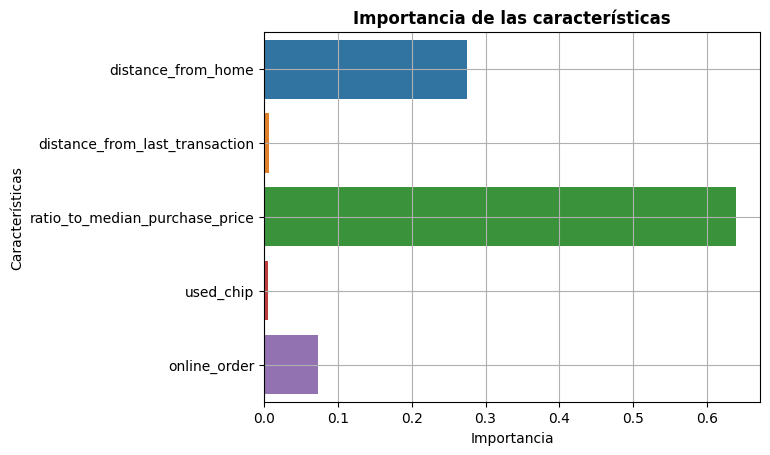

Tiempo de ejecución: 108.20861101150513 segundos


In [661]:
start_time = time.time()

param_grid = {
    'n_estimators': [10, 20, 30, 40],     # Número de árboles en el bosque.
    'max_depth': [None, 10, 20, 30],      # Profundidad máxima del árbol.
    # 'min_samples_split': [2, 5, 10],    # Número mínimo de muestras necesarias para dividir un nodo.
    # 'min_samples_leaf': [1, 2, 4],      # Número mínimo de muestras necesarias en un nodo hoja.
    'criterion': ['gini', 'entropy']      # Función para medir la calidad de una división.
}

fraud_detection.train_model(RandomForestClassifier(), params=param_grid, cv=3, save_model_path='modelo_rf.pkl')

end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time} segundos")

# Evaluación de resultados
---

La matriz de confusión y las métricas reportadas indican un rendimiento perfecto del modelo, con una precisión, exhaustividad (recall), puntuación F1 y exactitud (accuracy) de 1.0. Esto significa que el modelo clasificó correctamente todas las instancias de prueba sin errores. Sin embargo, en situaciones prácticas, un resultado tan perfecto es altamente improbable y a menudo sugiere una revisión crítica por sobreajuste o errores en la validación.

Si los resultados no fueran perfectos, la métrica más importante para este problema, dado su carácter desbalanceado (fraude vs no fraude), sería la exhaustividad (recall). Esto se debe a que en el contexto del fraude de tarjetas de crédito, es crítico identificar todas las transacciones fraudulentas posibles, incluso si eso significa tener algunos falsos positivos (transacciones legítimas identificadas erróneamente como fraude), ya que el coste de no detectar el fraude es generalmente más alto que el de investigar transacciones sospechosas que resultan ser legítimas.

,accuracy,f1_score,precision,recall
0,1.0,1.0,1.0,1.0


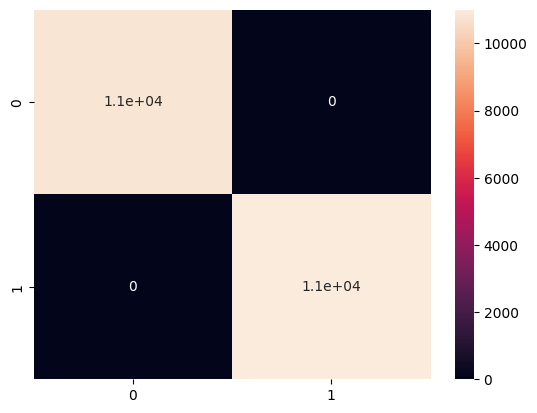

In [662]:
evaluation_results = fraud_detection.evaluate_model()
evaluation_results

# Análisis final
---

Se ha procedido a importar el modelo previamente entrenado y guardado utilizando la biblioteca pickle. El modelo, una vez cargado, se utilizo para hacer predicciones sobre ''data_without_outliers_no_undersampling'' (conjunto de datos no utilizado en el proceso de undersampling), con el fin de hacer una evaluación final. Los resultados obtenidos son los esperados, se ha obteniendo una clasificación perfecta de la clase 0, la cual era la unica en este conjunto de datos.

In [663]:
# Ruta del archivo donde se encuentra el modelo entrenado
modelo_guardado_path = 'modelo_rf.pkl'

# Cargar el modelo desde el archivo
with open(modelo_guardado_path, 'rb') as model_file:
    modelo_cargado = pickle.load(model_file)

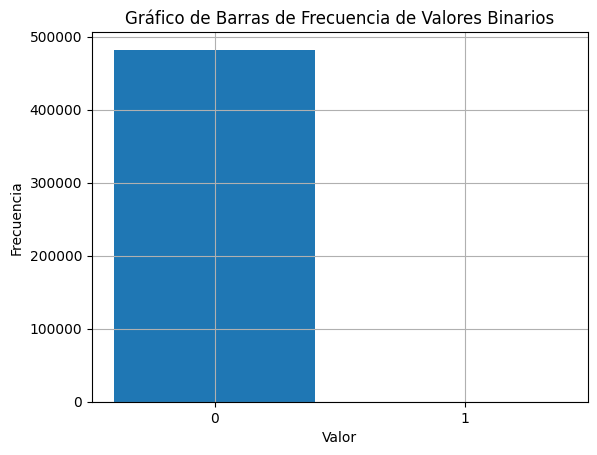

In [664]:
predicciones = modelo_cargado.predict(data_without_outliers_no_undersampling.drop(['fraud'],axis=1))

# Calcular la frecuencia de cada valor
frecuencia_0 = np.sum(predicciones == 0)
frecuencia_1 = np.sum(predicciones == 1)
# Etiquetas para las barras
etiquetas = ['0', '1']
# Valores de frecuencia
valores = [frecuencia_0, frecuencia_1]

# Crear un gráfico de barras
plt.bar(etiquetas, valores)
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Gráfico de Barras de Frecuencia de Valores Binarios')
plt.grid(True)
plt.show()